In [6]:
!pip install pyspark

In [9]:
import pandas as pd

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import tensorflow as tf

from tensorflow import keras

print(tf.version.VERSION)


2.15.0


In [12]:
# load dataset as numpy arrays
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

11490434/11490434 [==============================] - 2s 0us/step


((60000, 28, 28), (10000, 28, 28))

In [7]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

spark = SparkSession \
.builder \
.appName("spark-dl-inference") \
.master("local[*]") \
.config("spark.executor.memory", "8g") \
.config("spark.driver.memory", "8g") \
.config("spark.python.worker.reuse",True) \
.getOrCreate()
# Create a SparkConf object
conf=SparkConf()

print("spark.executor.memory = ", conf.get("spark.executor.memory"))
print("spark.driver.memory = ", conf.get("spark.driver.memory"))


spark.executor.memory =  None
spark.driver.memory =  None


In [13]:
train_labels.shape

(60000,)

In [14]:
X = np.concatenate([train_images, test_images])
y = np.concatenate([train_labels, test_labels])
X.shape, y.shape

((70000, 28, 28), (70000,))

In [15]:
from sklearn.model_selection import train_test_split
DATASET_SIZE = 70000
TRAIN_RATIO = 0.9
TEST_RATIO = 0.1
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=(1-TRAIN_RATIO))

In [16]:
# flatten and normalize
train_images_1D = train_images.reshape(-1, 784) / 255.0
test_images_1D = test_images.reshape(-1, 784) / 255.0

In [17]:
train_images_1D.shape, test_images_1D.shape

((63000, 784), (7000, 784))

In [18]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
train_images = train_images / 255.0
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1)
test_images = test_images /255.0
train_images.shape, test_images.shape

((63000, 28, 28, 1), (7000, 28, 28, 1))

In [19]:
# Define a simple FCN model
def create_dense_model():
    model = tf.keras.models.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(784,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[tf.metrics.SparseCategoricalAccuracy()])

    return model

# Create a basic model instance
dense_model = create_dense_model()

# Display the model's architecture
dense_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
input_shape = (28, 28, 1)
# Define a simple CNN model
def create_CNN_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(strides=(2,2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])


    return model

# Create a basic model instance
CNN_model = create_CNN_model()

# Display the model's architecture
CNN_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                     

In [21]:
dense_model.fit(train_images_1D,
          train_labels,
          epochs=5,
          validation_data=(test_images_1D, test_labels))

Epoch 1/5

1969/1969 [==============================] - 11s 5ms/step - loss: 0.2135 - sparse_categorical_accuracy: 0.9371 - val_loss: 0.1292 - val_sparse_categorical_accuracy: 0.9574
Epoch 2/5
1969/1969 [==============================] - 13s 6ms/step - loss: 0.0928 - sparse_categorical_accuracy: 0.9711 - val_loss: 0.0982 - val_sparse_categorical_accuracy: 0.9696
Epoch 3/5
1969/1969 [==============================] - 8s 4ms/step - loss: 0.0665 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.0949 - val_sparse_categorical_accuracy: 0.9729
Epoch 4/5
1969/1969 [==============================] - 8s 4ms/step - loss: 0.0524 - sparse_categorical_accuracy: 0.9829 - val_loss: 0.0847 - val_sparse_categorical_accuracy: 0.9739
Epoch 5/5
1969/1969 [==============================] - 12s 6ms/step - loss: 0.0419 - sparse_categorical_accuracy: 0.9857 - val_loss: 0.0833 - val_sparse_categorical_accuracy: 0.9770


In [22]:
test_img_1D = test_images_1D[:1]
prediction = dense_model.predict(test_img_1D)
prediction

1/1 [==============================] - 0s 226ms/step


array([[-13.5157175,  -3.070777 ,  13.363666 ,  -4.9265337,  -6.419355 ,
        -10.36186  ,  -4.50889  ,  -5.360558 ,  -1.210833 , -13.618066 ]],
      dtype=float32)

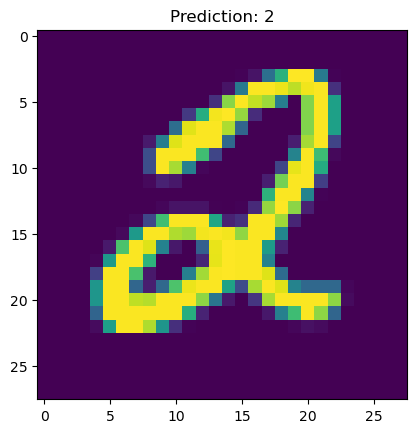

In [24]:
plt.figure()
plt.title("Prediction: {}".format(np.argmax(prediction)))
plt.imshow(test_img_1D.reshape(28,28))
plt.show()

In [25]:
y_train = tf.one_hot(train_labels.astype(np.int32), depth=10)
y_test = tf.one_hot(test_labels.astype(np.int32), depth=10)

In [26]:
y_train.shape

TensorShape([63000, 10])

In [27]:
train_images.shape

(63000, 28, 28, 1)

In [28]:
test_images.shape

(7000, 28, 28, 1)

In [29]:
CNN_model.fit(train_images,
          y_train,
          epochs=5,
          validation_data=(test_images, y_test))

Epoch 1/5

1969/1969 [==============================] - 69s 34ms/step - loss: 0.1666 - acc: 0.9502 - val_loss: 0.0651 - val_acc: 0.9810
Epoch 2/5
1969/1969 [==============================] - 71s 36ms/step - loss: 0.0698 - acc: 0.9804 - val_loss: 0.0433 - val_acc: 0.9867
Epoch 3/5
1969/1969 [==============================] - 80s 41ms/step - loss: 0.0608 - acc: 0.9834 - val_loss: 0.0498 - val_acc: 0.9881
Epoch 4/5
1969/1969 [==============================] - 81s 41ms/step - loss: 0.0579 - acc: 0.9843 - val_loss: 0.0411 - val_acc: 0.9879
Epoch 5/5
1969/1969 [==============================] - 80s 41ms/step - loss: 0.0591 - acc: 0.9849 - val_loss: 0.0414 - val_acc: 0.9891


In [30]:
test_loss, test_acc = CNN_model.evaluate(test_images, y_test)

219/219 [==============================] - 3s 11ms/step - loss: 0.0414 - acc: 0.9891


In [31]:
import os
model_dir = os.path.join(os. getcwd(), "mnist_dense_model")

In [32]:
dense_model.save('mnist_dense_model')

INFO:tensorflow:Assets written to: mnist_dense_model\assets


INFO:tensorflow:Assets written to: mnist_dense_model\assets


In [33]:
CNN_model_dir = os.path.join(os. getcwd(), "mnist_CNN_model")

In [34]:
CNN_model.save('mnist_CNN_model')

INFO:tensorflow:Assets written to: mnist_CNN_model\assets


INFO:tensorflow:Assets written to: mnist_CNN_model\assets


In [35]:
new_model = tf.keras.models.load_model('mnist_dense_model')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
new_model.inputs

[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'dense_input')>]

In [37]:
new_CNN_model = tf.keras.models.load_model('mnist_CNN_model')
new_CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                      

In [38]:
new_model.predict(test_images_1D[:1])

1/1 [==============================] - 0s 92ms/step


array([[-13.5157175,  -3.070777 ,  13.363666 ,  -4.9265337,  -6.419355 ,
        -10.36186  ,  -4.50889  ,  -5.360558 ,  -1.210833 , -13.618066 ]],
      dtype=float32)

In [39]:
example = test_images_1D[:1]

In [41]:
example.shape
example = test_images[:1]
new_CNN_model.predict(test_images[:1])

1/1 [==============================] - 0s 191ms/step


array([[4.6484592e-14, 3.0058970e-12, 1.0000000e+00, 4.6788985e-14,
        8.7341125e-15, 4.5458533e-19, 5.7536149e-15, 8.6449589e-12,
        1.7475658e-11, 1.0818055e-17]], dtype=float32)

In [44]:
# numpy array to pandas DataFrame
test_pdf = pd.DataFrame(test_images_1D)
test_pdf.shape

(7000, 784)

In [45]:
%%time
df = spark.createDataFrame(test_pdf)

CPU times: total: 19.8 s
Wall time: 1min 2s


In [49]:
%%time
df.write.mode("overwrite").parquet("mnist_784")

Py4JJavaError: An error occurred while calling o67.parquet.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 3.0 failed 1 times, most recent failure: Lost task 4.0 in stage 3.0 (TID 28) (LAPTOP-II9OQKGK executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeWrite$4(FileFormatWriter.scala:307)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:271)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:304)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:190)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:190)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:859)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:388)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:361)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:240)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:792)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:131)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:189)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more
